In [1]:
import datetime as dt
import gc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import geopandas as gpd

from pathlib import Path
from tqdm import tqdm

#####--
import numpy as np
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from numpy.random import randn
from numpy.random import randint
import numpy.random as random

#Keras and tensorflow
import csv
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable

import keras
import tensorflow as tf
import torch
from keras.models import load_model

from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras import backend

from mpl_toolkits.axes_grid1 import make_axes_locatable


import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

C:\Users\Remote\anaconda3\envs\TF_V0\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load historical data
NPZ_Data=np.load("AggregatedData_Daily.npz", allow_pickle=True) 
EnergyPu=NPZ_Data["EnergyPu"]
Lat=NPZ_Data["Lat"]
Long=NPZ_Data["Long"]
EnergyPu=NPZ_Data["EnergyPu"]
StartYear=NPZ_Data["StartYear"]
EndYear=NPZ_Data["EndYear"]
WindEnergy_RatedPower=float(NPZ_Data["WindEnergy_RatedPower"])
WaveEnergy_RatedPower=float(NPZ_Data["WaveEnergy_RatedPower"])
OceanEnergy_RatedPower=float(NPZ_Data["OceanEnergy_RatedPower"])

NPZ_Data_Yearly=np.load("AggregatedData_Daily.npz", allow_pickle=True) 
EnergyPu_Yearly=NPZ_Data_Yearly["EnergyPu"]

Idx_Exclude=np.max(EnergyPu_Yearly[:,:,:,1],axis=0)<=0.001
EnergyPu[:,Idx_Exclude,:]=0

Idx_Exclude_Ocean=np.max(EnergyPu_Yearly[:,:,:,2],axis=0)<=0.05
EnergyPu[:,Idx_Exclude_Ocean,2]=0
    
#EnergyPu=np.round(EnergyPu*255)#Put data in image format for convenience
#Extend data 25x25> 26x26 to improve in the padding

Idx_Exclude=np.max(EnergyPu_Yearly[:,:,:,1],axis=0)>0.05

Idx_Exclude_Ocean=np.max(EnergyPu_Yearly[:,:,:,2],axis=0)>0.05
Idx_Exclude_Ocean=np.reshape(Idx_Exclude_Ocean*1,(25,25,1))

Idx_Exclude=np.reshape(Idx_Exclude*1,(25,25,1))
Idx_Exclude=np.repeat(Idx_Exclude,2,axis=2)

Idx_Exclude=np.concatenate((Idx_Exclude,Idx_Exclude_Ocean),axis=2)
Idx_Exclude=Idx_Exclude==1


min_E=np.mean(EnergyPu,axis=0)
MaxMin=1



In [3]:
#Get mean and STD
from tqdm import tqdm
from keras.models import load_model
def generate_latent_points(latent_dim_G, n_samples):
  x_input = randn(latent_dim_G * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim_G)

  return x_input

#GENERATOR = load_model("/home/victor-duraes/Projects/Ocean2/GANs/SaveStep/GENERATOR_C2.hdf5")
GENERATOR = load_model("GENERATOR"+".hdf5")#4420
latent_dim_G=GENERATOR.input_shape[1]
n_samples=365*50
x_input=generate_latent_points(latent_dim_G, n_samples)
Y_Generator=(GENERATOR.predict(x_input))+min_E

Y_Generator[:,Idx_Exclude==0]=0
Y_Generator[Y_Generator>1]=1
Y_Generator[Y_Generator<0]=0

#Y_Generator=EnergyPu #get real data

Mean=np.mean(EnergyPu,axis=0)
ID_NotZero=Mean>0.05
NumWind=np.sum(ID_NotZero[:,:,0])
NumWave=np.sum(ID_NotZero[:,:,1])
NumOC=np.sum(ID_NotZero[:,:,2])


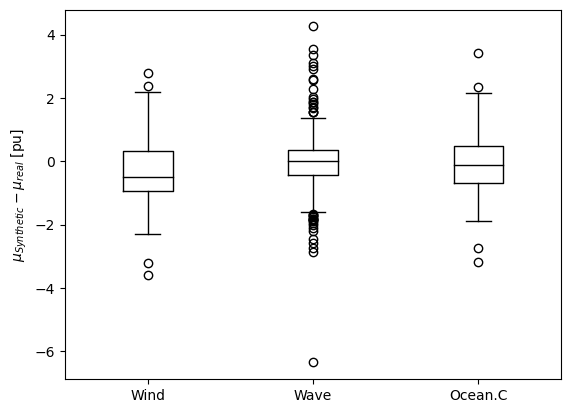

In [37]:

MU_R=np.mean(EnergyPu,axis=0)
ID_NotZero=MU_R>0.05
MU_R=np.mean(EnergyPu[:],axis=0)[ID_NotZero]
MU_S=np.mean(Y_Generator[0:30000,:],axis=0)[ID_NotZero]

STD_S=np.cov(np.transpose(Y_Generator[:,ID_NotZero]))
STD_R=np.cov(np.transpose(EnergyPu[:,ID_NotZero]))


MeanWind_R = MU_R[0:NumWind]
MeanWave_R = MU_R[NumWind:NumWind+NumWave]
MeanOcean_R= MU_R[NumWind+NumWave:]
MeanWind_S = MU_S[0:NumWind]
MeanWave_S = MU_S[NumWind:NumWind+NumWave]
MeanOcean_S= MU_S[NumWind+NumWave:]

MeanWindDiff=MeanWind_S-MeanWind_R
MeanWaveDiff=MeanWave_S-MeanWave_R
MeanOceanDiff=MeanOcean_S-MeanOcean_R

MeanWindDiff=MeanWindDiff/MeanWind_R*100
MeanWaveDiff=MeanWaveDiff/MeanWave_R*100
MeanOceanDiff=MeanOceanDiff/MeanOcean_R*100

Fig=plt.figure()
medianprops = dict(color="black")
plt.boxplot([MeanWindDiff,MeanWaveDiff,MeanOceanDiff],labels=['Wind','Wave','Ocean.C'], medianprops=medianprops)
plt.ylabel('$\mu_{Synthetic} - \mu_{real}$ [pu]')
#plt.savefig("Mean.png",dpi=600,bbox_inches='tight')
plt.show()

In [4]:
Historical_ConcatenatedEnergyData=np.load("AggregatedData_Daily.npz",allow_pickle=True)
Lat=Historical_ConcatenatedEnergyData["Lat"]
Long=Historical_ConcatenatedEnergyData["Long"]

LatLong_10=[] #Original Synthetic/Real data resolution just for precision computations
for i in Lat:
  for j in Long:
    LatLong_10.append(np.array([i,j]))

LatLong_10=np.array(LatLong_10)

LatLong_2=[] #High resolution just for precision computation, Costs are computed at the high resolution and then average to the data resolution
for i in range(3400,3660,2):
  for j in range(-7700,-7440,2):
    LatLong_2.append(np.array([i/100,j/100]))

LatLong_2=np.array(LatLong_2)

In [5]:
Depth_NETCDF = xr.open_dataset("Depths.nc")#File with bathymetry data
CoastLine=[]

File_CoastLine=open('Coastline_NC.csv', "r")
File_CoastLine_csv=csv.reader(File_CoastLine,delimiter=',')

for EachLine in File_CoastLine_csv:

    if File_CoastLine_csv.line_num > 1:
        CoastLine.append([float(EachLine[1]), float(EachLine[0])] ) #LatLong

CoastLine=np.array(CoastLine)

def GetDepth(Lat,Long):
    
    I_lat=np.argmin(np.square(Depth_NETCDF.lat.data-Lat))
    I_lon=np.argmin(np.square(Depth_NETCDF.lon.data-Long))
    
    depth=-Depth_NETCDF.elevation.data[I_lat,I_lon]  
    
    return depth

def GetDistanceToShore (CoastLine, LatLong1): #Compute distance to shore in km of a lat long point
   
    CoastLine=CoastLine*2*np.pi/360
    LatLong1=LatLong1*2*np.pi/360
    
    LatLong1=np.reshape(LatLong1,(1,2))
    dLat=LatLong1[:,0]-CoastLine[:,0]
    dLong=LatLong1[:,1]-CoastLine[:,1]
    
    a=np.power(np.sin(dLat/2),2)+np.cos(CoastLine[:,0])*np.cos(LatLong1[:,0])*np.power(np.sin(dLong/2),2)
    c=2*np.arcsin(np.minimum(1,np.sqrt(a)))
    d=6367*c
    
    Distance=np.min(d) #Minimum distance to shore km
    
    return Distance

def DistanceBetweenLatLong(LatLong1, LatLong2):
    LatLong1=LatLong1*2*np.pi/360
    LatLong2=LatLong2*2*np.pi/360
    
    dLat=np.reshape(LatLong1[:,0],(len(LatLong1[:,0]),1))-np.reshape(LatLong2[:,0],(1,len(LatLong2[:,0])))
    dLong=np.reshape(LatLong1[:,1],(len(LatLong1[:,1]),1))-np.reshape(LatLong2[:,1],(1,len(LatLong2[:,1])))
    
    P1=np.repeat(np.reshape(np.cos(LatLong1[:,0]),(LatLong1.shape[0],1)),LatLong2.shape[0],axis=1)
    P2=np.repeat(np.reshape(np.cos(LatLong2[:,0]),(1,LatLong2.shape[0])),LatLong1.shape[0],axis=0)
    
    a=np.power(np.sin(dLat/2),2) + P1*P2*np.power(np.sin(dLong/2),2)
    c=2*np.arcsin(np.minimum(1,np.sqrt(a)))
    Distance=6367*c #[km]
    
    return Distance

Depths=[]
DistancesFromShore=[]
for i in tqdm(range(len(LatLong_2))):
  Depths.append(GetDepth(LatLong_2[i,0], LatLong_2[i,1]))
  DistancesFromShore.append(GetDistanceToShore(CoastLine, LatLong_2[i,:]))

Depths=np.array(Depths)
DistancesFromShore=np.array(DistancesFromShore)

100%|██████████████████████████████████████████████████████████████████████████| 16900/16900 [00:02<00:00, 5887.35it/s]


## Wind Cost

In [6]:
######File with the NC wind sites considered by the NREL
NREL_File="wtk_site_summary2007_2014.csv" 
LatLong_NREL=[]

#Read NREL file and get lat long
with open(NREL_File) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count >=1:
            LatLong_NREL.append([row[2],row[1]])
            
        line_count += 1
LatLong_NREL=np.asarray(LatLong_NREL,dtype=float)

Depths_NREL=[]
DistancesFromShore_NREL=[]
for i in range(len(LatLong_NREL)):
  Depths_NREL.append(GetDepth(LatLong_NREL[i,0], LatLong_NREL[i,1]))
  DistancesFromShore_NREL.append(GetDistanceToShore(CoastLine, LatLong_NREL[i,:]))

Depths_NREL=np.array(Depths_NREL)
DistancesFromShore_NREL=np.array(DistancesFromShore_NREL)

FCR=8.8/100 # Factor of Capital Return(NREL: https://www.nrel.gov/docs/fy18osti/72167.pdf)

RatedPowerOfTurbine=6 #[MW]
NREL_WaterDepth=np.array([18,22,24,29,31,144,159,157,148,107,375,467,663,432,468]) #[m]
NREL_ShoreDistance=np.array([27,29,33,57,65,38,45,46,64,101,116,116,166,147,133]) #[km]

NREL_CAPEX=np.array([3361,3475,3660,4001,4633,4602,4661,4710,4936,5209,5320,5331,5785,6145,6599]) #[$/kW]
NREL_OPEX=np.array([105,106,109,112,107,77,78,78,84,91,98,97,92,87,83]) #[$/(kW*Year)]

NREL_CAPEX=NREL_CAPEX*RatedPowerOfTurbine*(10**-3) #[M$]
NREL_OPEX=NREL_OPEX*RatedPowerOfTurbine*(10**-3) #[$/Year]


Diff_Depth=np.reshape(Depths_NREL,(len(Depths_NREL),1))-np.reshape(NREL_WaterDepth,(1,len(NREL_WaterDepth)))
Diff_Distance=np.reshape(DistancesFromShore_NREL,(len(DistancesFromShore_NREL),1))-np.reshape(NREL_ShoreDistance,(1,len(NREL_ShoreDistance)))

EuclidianDistance=(Diff_Depth**2+Diff_Distance**2)
Idx_NRELTurbine=np.argmin(EuclidianDistance,axis=1)

AnnualizedCostWind=NREL_CAPEX[Idx_NRELTurbine]*FCR + NREL_OPEX[Idx_NRELTurbine] # in M$/Turbine-Year

#Changing data to the resolution of the synthetic data
Distance_LatLongs=DistanceBetweenLatLong(LatLong_10, LatLong_NREL)
Idx_latLong=np.argmin(Distance_LatLongs,axis=0)
MaxNumOfTurbines=np.zeros((len(LatLong_10)) ,dtype=float)
AverageAnnualCostPerTurbine=np.zeros((len(LatLong_10)) ,dtype=float)

for i in range(len(Idx_latLong)):
  MaxNumOfTurbines[Idx_latLong[i]]+=1
  AverageAnnualCostPerTurbine[Idx_latLong[i]]+=AnnualizedCostWind[i]

Mask_Wind=MaxNumOfTurbines>0
LatLong_Wind=LatLong_10 # The mask will be incorporated at the end of the code with additional considerations
AverageAnnualCostPerWindTurbine=AverageAnnualCostPerTurbine
MaxNumOfWindTurbines=MaxNumOfTurbines

## Cost Wave

In [7]:
def ComputeAnnualCost(DistanceShoreToPlatform, TotalMorringChainLength, LengthCable34kV=None):
    
    #TotalMorringChainLength: Not used in the current code, but kept here in case we decide to do
    #a more detailed modeling for the wave technology
    
    #Default Values
    NumTurbines=100
    RatedPower=1.5#Rated power for one device [MW]

    
    if LengthCable34kV==None:
        LengthCable34kV=NumTurbines*1# (No platform was considered)[km]
    
    FCR=11.3/100 #Fixed Charge Rate
      
    ##---------------------#Wave energy CAPEX----------------------------------------------------------##    
    #Manufacturing cost
    CAPEX_OC = 1269.6 + 1.003*DistanceShoreToPlatform + 0.186*LengthCable34kV

    OPEX_OC=30.4868 + 0.025*DistanceShoreToPlatform + 4.5*(10**-3)*LengthCable34kV
    ##---------------------#Annualized Cost----------------------------------------------------------##      
    AnnCost=(CAPEX_OC)*FCR + (OPEX_OC)
    
    return AnnCost

AnnualizedCostWave=[]
for i in range(len(Depths)):
    TotalMorringChainLength=Depths[i]*100/1000#[km]
    DistanceShoreToPlatform=DistancesFromShore[i]
    
    UnitCost=ComputeAnnualCost(DistanceShoreToPlatform, TotalMorringChainLength)
    UnitCost=UnitCost/100
    AnnualizedCostWave.append(UnitCost)
    
AnnualizedCostWave=np.array(AnnualizedCostWave)      

Distance_LatLongs=DistanceBetweenLatLong(LatLong_10, LatLong_2[(Depths>=50)*(Depths<=150),:])
Idx_latLong=np.argmin(Distance_LatLongs,axis=0)
MaxNumOfTurbines=np.zeros((len(LatLong_10)) ,dtype=float)
AverageAnnualCostPerTurbine=np.zeros((len(LatLong_10)) ,dtype=float)

for i in range(len(Idx_latLong)):
  MaxNumOfTurbines[Idx_latLong[i]]+=1
  AverageAnnualCostPerTurbine[Idx_latLong[i]]+=AnnualizedCostWave[i]

Mask_Wave=MaxNumOfTurbines>0
LatLong_Wave=LatLong_10 # The mask will be incorporated at the end of the code with additional considerations
AverageAnnualCostPerWaveTurbine=AverageAnnualCostPerTurbine
MaxNumOfWaveTurbines=MaxNumOfTurbines



## Cost Ocean Current

In [8]:
def ComputeAnnualCost(DistanceShoreToPlatform, TotalMorringChainLength, LengthCable34kV=None):
    
    #Default Values
    NumTurbines=50
    RatedPower=4#Rated power for one device [MW]
    #DistanceShoreToPlatform=150# [km]
    #TotalMorringChainLength=NumTurbines*1000# [km]
    
    if LengthCable34kV==None:
        LengthCable34kV=NumTurbines*1.5 #[km]
    
    FCR=11.3/100 #Fixed Charge Rate
    
    ##---------------------#Transmission Cost------------------------------------------------------------##
    #For a TL with Capacity for 50 Devices
    if DistanceShoreToPlatform<66:
        CAPEX_Transmission=19.31 + 1.28*DistanceShoreToPlatform
        
    else:
        CAPEX_Transmission=69.98 + 0.50*DistanceShoreToPlatform  
    
    OPEX_Transmission=2.5/100*CAPEX_Transmission
    
    
    ##---------------------#Ocean Current CAPEX----------------------------------------------------------##
    
    #Development costs
    DevelopmentCost=-13.5643 + 10.37*np.log(NumTurbines*RatedPower + 3.7)# Regression from SANDIA report 
    
    #Infrastructure
    Infrastructure= 0.4245*LengthCable34kV+ 30*np.ceil(NumTurbines/40)
    
    #Mooring/Foundation
    Mooring_Foundation= 1.5317*NumTurbines+ 0.344*TotalMorringChainLength + 0.4034
    
    #Device Structural Components
    StructuralComponentsCost=1.23*(-3.879*10**(-3)*NumTurbines**2 + 5.0876*NumTurbines + 5.613)
    
    #Power Take Off
    PowerTakeOff=-18.787*10**(-3)*NumTurbines**2 + 12.3961*NumTurbines + 16.0626 
    
    ##### Subsystem Integration and Profit Margin
    Integration_ProfitMargin=0.1*(StructuralComponentsCost + PowerTakeOff)
    
    #Instalation
    Instalation=1.271375*NumTurbines + 6.9445*10**(-3)*NumTurbines*DistanceShoreToPlatform \
    + 18.2521*10**(-3)*DistanceShoreToPlatform + 0.11357*LengthCable34kV + 8.73053
    
    #Contingency
    Contingency=0.1*(Infrastructure+Mooring_Foundation\
                +StructuralComponentsCost+PowerTakeOff+Integration_ProfitMargin+Instalation)
    
    CAPEX_OC=DevelopmentCost+Infrastructure+Mooring_Foundation+StructuralComponentsCost+PowerTakeOff\
    +Integration_ProfitMargin+Instalation+Contingency
    
    ##---------------------#Ocean Current OPEX----------------------------------------------------------##
    
    #Insurance
    Insurance=0.01*CAPEX_OC
    
    #Environmental and Regulatory Compliance
    Environmental_RegulatoryCompliance=2.036 
    
    #Offshore Operations
    MarineOperations=5.128*10**(-6)*NumTurbines*(17925 + 150*DistanceShoreToPlatform)
    
    #Shore Operations
    ShoresideOperations=15.555*10**(-3)*NumTurbines + 0.2205 
    
    #Replacement Parts
    ReplacementParts= 0.86/100*PowerTakeOff
    
    #Consumables
    Consumables=17.494 *10**(-3)*NumTurbines
    
    OPEX_OC=Insurance+Environmental_RegulatoryCompliance+ MarineOperations +ShoresideOperations\
        + ReplacementParts+ Consumables
       
    ##---------------------#Annualized Cost----------------------------------------------------------##      
    AnnCost=(CAPEX_Transmission+ CAPEX_OC)*FCR + (OPEX_Transmission+ OPEX_OC)
    
    return AnnCost

AnnualizedCostOcean=[]
for i in range(len(Depths)):
    TotalMorringChainLength=Depths[i]*50/1000#[km]
    DistanceShoreToPlatform=DistancesFromShore[i]
    
    UnitCost=ComputeAnnualCost(DistanceShoreToPlatform, TotalMorringChainLength)
    UnitCost=UnitCost/50
    AnnualizedCostOcean.append(UnitCost)
    
AnnualizedCostOcean=np.array(AnnualizedCostOcean)


Distance_LatLongs=DistanceBetweenLatLong(LatLong_10, LatLong_2[(Depths>=100)*(Depths<=2500),:])
Idx_latLong=np.argmin(Distance_LatLongs,axis=0)    
MaxNumOfTurbines=np.zeros((len(LatLong_10)) ,dtype=float)
AverageAnnualCostPerTurbine=np.zeros((len(LatLong_10)) ,dtype=float)

for i in range(len(Idx_latLong)):
  MaxNumOfTurbines[Idx_latLong[i]]+=1
  AverageAnnualCostPerTurbine[Idx_latLong[i]]+=AnnualizedCostOcean[i]

Mask_Ocean=MaxNumOfTurbines>0
LatLong_Ocean=LatLong_10 # The mask will be incorporated at the end of the code with additional considerations
AverageAnnualCostPerOceanTurbine=AverageAnnualCostPerTurbine
MaxNumOfOceanTurbines=MaxNumOfTurbines


## Compile Results

In [9]:

WindEnergy =Y_Generator[:,:,:,0]
WindEnergy=np.reshape(WindEnergy,(len(WindEnergy),-1))

WindEnergy_R =EnergyPu[:,:,:,0]
WindEnergy_R=np.reshape(WindEnergy_R,(len(WindEnergy_R),-1))

WaveEnergy =Y_Generator[:,:,:,1]
WaveEnergy=np.reshape(WaveEnergy,(len(WaveEnergy),-1))

WaveEnergy_R =EnergyPu[:,:,:,1]
WaveEnergy_R=np.reshape(WaveEnergy_R,(len(WindEnergy_R),-1))

OceanEnergy=Y_Generator[:,:,:,2]
OceanEnergy=np.reshape(OceanEnergy,(len(OceanEnergy),-1))

OceanEnergy_R=EnergyPu[:,:,:,2]
OceanEnergy_R=np.reshape(OceanEnergy_R,(len(OceanEnergy_R),-1))

#Wind
Mask_Wind=Mask_Wind*(np.mean(WindEnergy_R,axis=0)>0.01)

LatLong_Wind=LatLong_Wind[Mask_Wind]
AverageAnnualCostPerWindTurbine=AverageAnnualCostPerWindTurbine[Mask_Wind]
AverageAnnualCostPerWindTurbine=AverageAnnualCostPerWindTurbine/MaxNumOfWindTurbines[Mask_Wind]
MaxNumOfWindTurbines=MaxNumOfWindTurbines[Mask_Wind]*4


#Wave
Mask_Wave=Mask_Wave*(np.mean(WaveEnergy_R,axis=0)>0.01)

LatLong_Wave=LatLong_Wave[Mask_Wave]
AverageAnnualCostPerWaveTurbine=AverageAnnualCostPerWaveTurbine[Mask_Wave]
AverageAnnualCostPerWaveTurbine=AverageAnnualCostPerWaveTurbine/MaxNumOfWaveTurbines[Mask_Wave]
MaxNumOfWaveTurbines=MaxNumOfWaveTurbines[Mask_Wave]*100 # The packing density of this technology is 12turbines/km^2 . The number 100 is an lowerbound to facilitate the computation


#Ocean
Mask_Ocean=Mask_Ocean*(np.mean(OceanEnergy_R,axis=0)>0.01)

LatLong_Ocean=LatLong_Ocean[Mask_Ocean]
AverageAnnualCostPerOceanTurbine=AverageAnnualCostPerOceanTurbine[Mask_Ocean]
AverageAnnualCostPerOceanTurbine=AverageAnnualCostPerOceanTurbine/MaxNumOfOceanTurbines[Mask_Ocean]
MaxNumOfOceanTurbines=MaxNumOfOceanTurbines[Mask_Ocean]*4

#Synthetic data
WindEnergy=WindEnergy[:,Mask_Wind]
WaveEnergy=WaveEnergy[:,Mask_Wave]
OceanEnergy=OceanEnergy[:,Mask_Ocean]


#Covnert energy in pu to MW
RatedPowerWind  = 6
RatedPowerWave  = 1.5
RatedPowerOcean = 4

#Data in MW
WindEnergy=WindEnergy*RatedPowerWind
WaveEnergy=WaveEnergy*RatedPowerWave
OceanEnergy=OceanEnergy*RatedPowerOcean

## Add Losses

In [10]:
def DistanceToShore (CoastLine, LatLong1): #Compute distance to shore in km of a lat long point
#For Ocean Current Only   
    CoastLine=CoastLine*2*np.pi/360
    LatLong1=LatLong1*2*np.pi/360
    
    LatLong1=np.reshape(LatLong1,(1,2))
    dLat=LatLong1[:,0]-CoastLine[:,0]
    dLong=LatLong1[:,1]-CoastLine[:,1]
    
    a=np.power(np.sin(dLat/2),2)+np.cos(CoastLine[:,0])*np.cos(LatLong1[:,0])*np.power(np.sin(dLong/2),2)
    c=2*np.arcsin(np.minimum(1,np.sqrt(a)))
    d=6367*c
    
    Distance=np.min(d) #Minimum distance to shore km
    
    return Distance

def EfficiencyTransmisison(LatLong):
    #For Ocean Current Only
    E_Transmission=[]
    for LatLong_i in LatLong:
        D=DistanceToShore(CoastLine, LatLong_i)
        if D<66:
            E_Transmission.append(-0.0362*D + 98.804)#HVAC
        else:
            E_Transmission.append(-0.0206*D + 96.432)#HVDC
            
    E_Transmission=np.array(E_Transmission)/100
    E_Transmission=np.reshape(E_Transmission,(1,len(E_Transmission)))
    
    return E_Transmission

E_Transmission=EfficiencyTransmisison(LatLong_Ocean)
OceanEnergy=OceanEnergy*0.90354432*0.95*0.98*E_Transmission #Combined power chain conversion efficiency, Availability Factor, E_Collecion


In [25]:

def EfficiencyTransmisison(LatLong):
    #For Ocean Current Only
    E_Transmission=[]
    for LatLong_i in LatLong:
        D=DistanceToShore(CoastLine, LatLong_i)
        if D<66:
            E_Transmission.append(-0.0251*D + 98.836)#HVAC
        else:
            E_Transmission.append(-0.0238*D + 96.432)#HVDC
            
    E_Transmission=np.array(E_Transmission)/100
    E_Transmission=np.reshape(E_Transmission,(1,len(E_Transmission)))
    
    return E_Transmission

E_Transmission=EfficiencyTransmisison(LatLong_Wave)
WaveEnergy=WaveEnergy*0.95*0.98*E_Transmission# losses due to device availability, E_Collecion, 


WindEnergy=WindEnergy*(1-0.158)#System Efficiency (Availability+Transmission+Collection, from NREL)


In [26]:
np.savez("SyntheticData_CVAR_S_GAN_WithLoss.npz",
         WindEnergy=WindEnergy,   WindLatLong=LatLong_Wind,   AverageAnnualCostPerWindTurbine=AverageAnnualCostPerWindTurbine, MaxNumOfWindTurbines=MaxNumOfWindTurbines,RatedPowerWind=RatedPowerWind,
         WaveEnergy=WaveEnergy,   WaveLatLong=LatLong_Wave,   AverageAnnualCostPerWaveTurbine=AverageAnnualCostPerWaveTurbine, MaxNumOfWaveTurbines=MaxNumOfWaveTurbines,RatedPowerWave=RatedPowerWave,
         OceanEnergy=OceanEnergy, OceanLatLong=LatLong_Ocean, AverageAnnualCostPerOceanTurbine=AverageAnnualCostPerOceanTurbine, MaxNumOfOceanTurbines=MaxNumOfOceanTurbines,RatedPowerOcean=RatedPowerOcean,
         Mask_Ocean=Mask_Ocean, Mask_Wind=Mask_Wind, Mask_Wave=Mask_Wave)

# np.savez("RealData_CVAR_S_GAN_WithLoss.npz",
#          WindEnergy=WindEnergy,   WindLatLong=LatLong_Wind,   AverageAnnualCostPerWindTurbine=AverageAnnualCostPerWindTurbine, MaxNumOfWindTurbines=MaxNumOfWindTurbines,RatedPowerWind=RatedPowerWind,
#          WaveEnergy=WaveEnergy,   WaveLatLong=LatLong_Wave,   AverageAnnualCostPerWaveTurbine=AverageAnnualCostPerWaveTurbine, MaxNumOfWaveTurbines=MaxNumOfWaveTurbines,RatedPowerWave=RatedPowerWave,
#          OceanEnergy=OceanEnergy, OceanLatLong=LatLong_Ocean, AverageAnnualCostPerOceanTurbine=AverageAnnualCostPerOceanTurbine, MaxNumOfOceanTurbines=MaxNumOfOceanTurbines,RatedPowerOcean=RatedPowerOcean,
#          Mask_Ocean=Mask_Ocean, Mask_Wind=Mask_Wind, Mask_Wave=Mask_Wave)